In [1]:
!pip install opencv-python

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


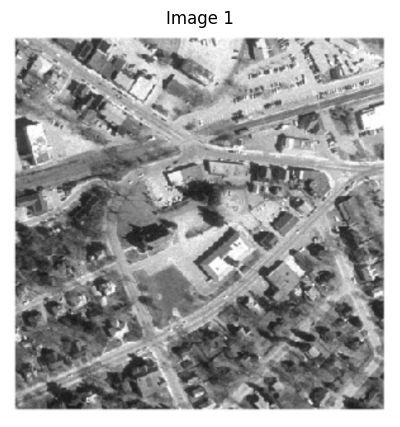

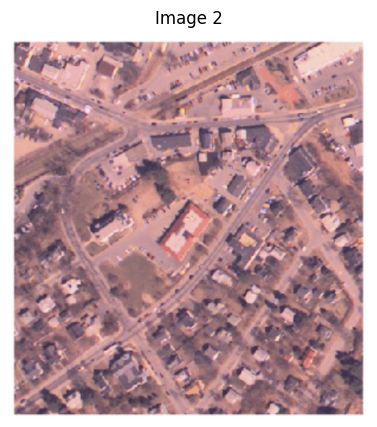

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load two images
img1 = cv2.imread('/content/drive/MyDrive/programming/1.png')
img2 = cv2.imread('/content/drive/MyDrive/programming/2.png')

# Display image 1
plt.figure(figsize=(5, 5))
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.title('Image 1')
plt.axis('off')
plt.show()

# Display image 2
plt.figure(figsize=(5, 5))
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.title('Image 2')
plt.axis('off')
plt.show()

# Resize images to have the same height
min_height = min(img1.shape[0], img2.shape[0])
img1 = cv2.resize(img1, (int(img1.shape[1] * min_height / img1.shape[0]), min_height))
img2 = cv2.resize(img2, (int(img2.shape[1] * min_height / img2.shape[0]), min_height))


### **ORB 特徵提取**
ORB（Oriented FAST and Rotated BRIEF）用於圖像特徵檢測和描述的演算法。ORB演算法結合了FAST（Features from Accelerated Segment Test）特徵檢測和BRIEF（Binary Robust Independent Elementary Features）描述符，同時添加了旋轉不變性。

* FAST特徵檢測：FAST是一種高速特徵檢測演算法，用於快速檢測圖像中的角點。它通過對像素周圍的圓形鄰域進行比較來識別角點。FAST演算法高效率，適用於實時應用，但對於旋轉、尺度和光照變化不具有不變性。

* BRIEF描述符：BRIEF是一種二進制描述符，用於描述檢測到的特徵點周圍的局部圖像區域。BRIEF描述符通過在特徵點周圍的像素對上應用隨機二進制測試來生成二進制字串。雖然計算速度快，但對於圖像的旋轉和尺度變化敏感。

* 旋轉不變性：ORB演算法通過引入方向賦予每個特徵點一個方向，使其具有旋轉不變性。這意味著即使圖像發生旋轉，ORB演算法仍然能夠正確地匹配特徵點。


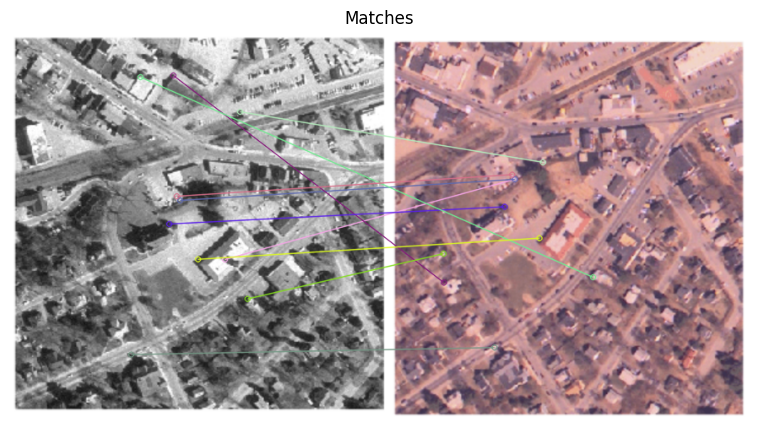

In [4]:

# Initiate ORB detector
orb = cv2.ORB_create()

# Find keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)
# Create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors
matches = bf.match(des1, des2)

# Sort them in the order of their distance
matches = sorted(matches, key=lambda x: x.distance)

# Draw top matches
img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.title('Matches')
plt.axis('off')
plt.show()


## **Homography**

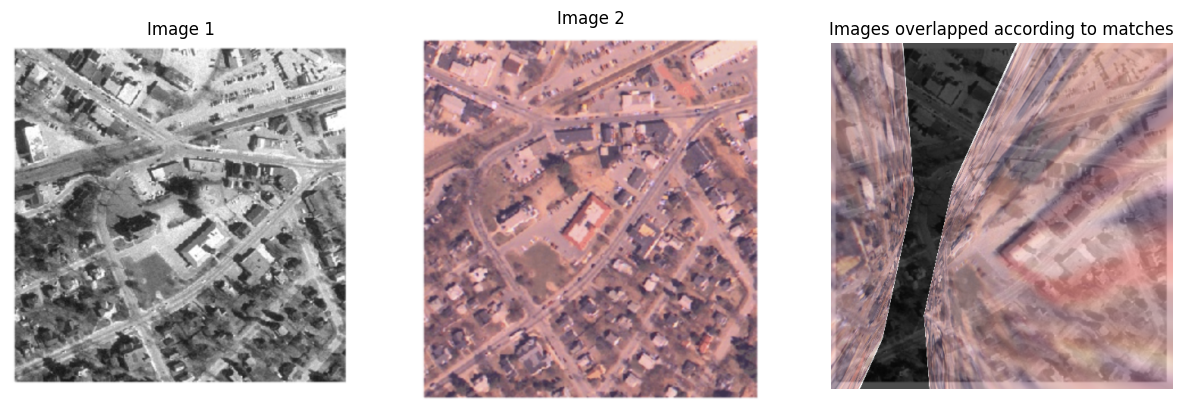

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Find matching points
good_matches = matches[:10]  # Adjust the number of matches to use
src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# Find perspective transform
M, _ = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC)

# Apply perspective transform to img2
img2_warped = cv2.warpPerspective(img2, M, (img1.shape[1], img1.shape[0]))

# Blend the two images
blend_alpha = 0.3  # Adjust transparency here
result = cv2.addWeighted(img1, blend_alpha, img2_warped, 1 - blend_alpha, 0)

# Display images and matches
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
axs[0].set_title('Image 1')
axs[0].axis('off')

axs[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
axs[1].set_title('Image 2')
axs[1].axis('off')

axs[2].imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
axs[2].set_title('Images overlapped according to matches')
axs[2].axis('off')

plt.show()


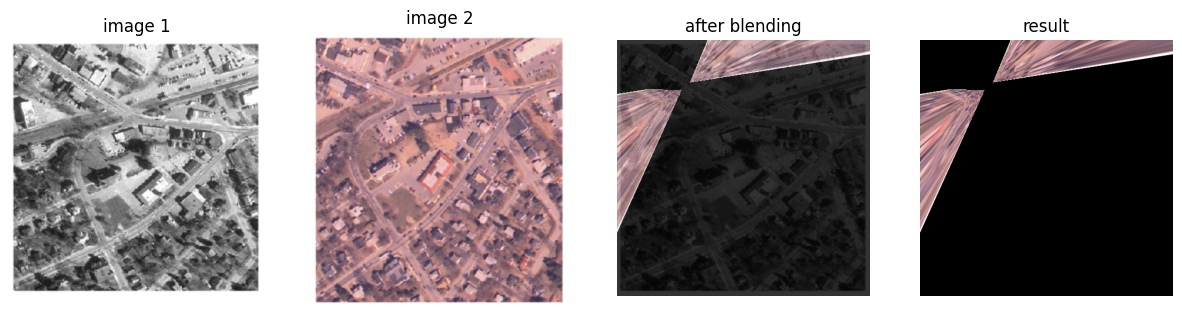

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def main():
  # load image
  img1_path = '/content/drive/MyDrive/programming/1.png'
  img2_path = '/content/drive/MyDrive/programming/2.png'
  img1 = cv2.imread(img1_path)
  img2 = cv2.imread(img2_path)

  if img1 is None or img2 is None:
      print("error: can't load image")
      return

  # transform into gray scale
  gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
  gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

  # key points and descriptor
  kp1, des1 = detect_and_describe(gray1)

  kp2, des2 = detect_and_describe(gray2)

  # matching feature
  matches = match_features(des1, des2)

  # find perspective transformation

  M = find_perspective_transform(kp1, kp2, matches)

  # warp the second image
  img2_warped = cv2.warpPerspective(img2, M, (img1.shape[1], img1.shape[0]))

  # blending
  result = blend_images(img1, img2_warped)

  # show result l
  display_images(img1, img2, result, img2_warped)

def detect_and_describe(image: np.ndarray) -> tuple:
  """
  Parameters:
      image (np.ndarray): 輸入的影像。

  Returns:
      tuple: 由關鍵點和特徵描述子組成的元組。
  """
  orb = cv2.ORB_create()
  kp, des = orb.detectAndCompute(image, None)
  return kp, des

def match_features(des1: np.ndarray, des2: np.ndarray) -> list:
  """
  匹配影像的特徵描述子。

  Parameters:
    des1 (np.ndarray): 第一個影像的特徵描述子。
    des2 (np.ndarray): 第二個影像的特徵描述子。

  Returns:
      list: 匹配的特徵點對。
  """
  bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
  matches = bf.match(des1, des2)
  matches = sorted(matches, key=lambda x: x.distance)
  return matches

def find_perspective_transform(kp1, kp2, matches):
  """
  找到兩個影像之間的透視變換。

  Parameters:
      kp1: 第一個影像的關鍵點。
      kp2: 第二個影像的關鍵點。
      matches: 匹配的特徵點對。

  Returns:
      np.ndarray: 透視變換矩陣。
  """
  good_matches = matches[:10]  # 調整要使用的匹配數量
  src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
  dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
  M, _ = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC)
  return M

def blend_images(img1, img2_warped, blend_alpha=0.2):
  """
  混合兩張影像。

  Parameters:
      img1: 第一張影像。
      img2_warped: 第二張影像經過透視變換後的影像。
      blend_alpha: 混合的 alpha 值。

  Returns:
      np.ndarray: 混合後的影像。
  """
  return cv2.addWeighted(img1, blend_alpha, img2_warped, 1 - blend_alpha, 0)

def display_images(img1, img2, result, img2_warped):
  """
  顯示影像。

  Parameters:
      img1: 第一張影像。
      img2: 第二張影像。
      result: 混合後的結果影像。
      img2_warped: 第二張影像經過透視變換後的影像。
  """
  fig, axs = plt.subplots(1, 4, figsize=(15, 5))
  axs[0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
  axs[0].set_title('image 1')
  axs[0].axis('off')

  axs[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
  axs[1].set_title('image 2')
  axs[1].axis('off')

  axs[2].imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
  axs[2].set_title('after blending')
  axs[2].axis('off')

  axs[3].imshow(cv2.cvtColor(img2_warped, cv2.COLOR_BGR2RGB))
  axs[3].set_title('result')
  axs[3].axis('off')

  plt.show()

if __name__ == "__main__":
  main()
